<a href="https://colab.research.google.com/github/maciejskorski/new_pll_trng/blob/main/TRNG_Dependency_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis Module

In [1]:
# update Python lib - and restart the kernel when necessary
!pip install --upgrade statsmodels --quiet
!pip install mlflow --quiet
!pip install pyngrok --quiet

     |████████████████████████████████| 9.8 MB 5.4 MB/s 
     |████████████████████████████████| 16.9 MB 5.2 MB/s 
     |████████████████████████████████| 79 kB 4.7 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 182 kB 45.7 MB/s 
     |████████████████████████████████| 147 kB 46.2 MB/s 
     |████████████████████████████████| 209 kB 59.4 MB/s 
     |████████████████████████████████| 78 kB 5.9 MB/s 
     |████████████████████████████████| 62 kB 210 kB/s 
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 140 kB 48.3 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 60 kB 5.5 MB/s 
     |████████████████████████████████| 745 kB 5.1 MB/s 


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pathlib import Path

from IPython.display import display
from pathlib import Path
import logging
import re

import mlflow
from pyngrok import ngrok
from getpass import getpass

plt.rcParams['figure.figsize'] = (10,3)
logger = logging.getLogger('TRNG Analysis')
logger.setLevel(logging.INFO)


def get_bytes_data(fpath):
  with open(fpath,'rb') as f:
    bytes_data = f.read()
  bytes_data = pd.DataFrame(list(bytes_data),columns=['byte value'])
  bytes_data.index.name = 'timestep'
  return bytes_data

def get_metadata(fpath):
  """ Read mean and alan variance, as stored in log* files """
  with open(fpath,'r') as f:
    metadata = f.read()
    rgx_mean = re.compile('\n\s+Mean:\s+(\d+.\d+)')
    rgx_alan = re.compile('\n\s+Allan variance:\s+(\d+.\d+)')
    mean = float(rgx_mean.search(metadata).group(1))
    var_alan = float(rgx_alan.search(metadata).group(1))
    return mean,var_alan

def counter_val(x):
  return x

def last_bit(x):
  return x % 2

def diff_last_bit(x):
  return x.diff().loc[1:] % 2


def analyze_series(bytes_data, nlags=10, alpha=0.05, postprocess_fn=last_bit):
  """ Analyze dependencies of TRNG bytes candidate.
      Args:
          bytes_data (pandas.DataFrame): series of raw bytes (das), encoded as integers uint8
          nlags (int): maximum number of lags to analyse
          alpha (float): confidence level for hypothesis testing
          postprocess_fn (function): transform applied to the series. For example, use <mod 2> to extract the last significant bit
      Return:
          figure: picture with plots
  """
  params = {
        'lags':nlags,
        'alpha':alpha,
        'postprocess_fn':postprocess_fn.__name__
  }
  mlflow.log_params(params)
  fig,axs = plt.subplots(1,2,constrained_layout=True)
  # plot histogram
  ax = axs[0]
  sns.histplot(data=bytes_data,x='byte value',ax=ax,discrete=True)
  # plot time series
  ax = axs[1]
  sns.lineplot(data=bytes_data.loc[:1000],x='timestep',y='byte value',ax=ax)
  plt.show()
  mlflow.log_figure(fig,'exploratory.png')
  bytes_data = postprocess_fn(bytes_data)
  # descriptive stats
  if postprocess_fn==counter_val:
    mlflow.log_metric('mean',bytes_data.mean())
  # stationarity tests on postprocessed data
  results = kpss(bytes_data,nlags=10)
  pval = results[1]
  mlflow.log_metric(f'stationary.KPSS.lag_{nlags}',pval)
  results = adfuller(bytes_data,maxlag=10)
  pval = results[1]
  mlflow.log_metric(f'not-stationary.ADF.lag_{nlags}',pval)
  # plot autocorelation by 
  fig,ax = plt.subplots(1,1,constrained_layout=True)
  fig = plot_acf(x=bytes_data, lags = nlags, fft=True, alpha=alpha, bartlett_confint=True, zero=False, adjusted=True, ax=ax, auto_ylims=True)
  ax.set(xlabel='Lag',ylabel='Corr')
  plt.show()
  mlflow.log_figure(fig,'autocorrelation.png')
  # find p-values for autocorrelation
  _,_,_,pvals = acf(
          x=bytes_data,
          nlags=nlags,
          alpha=alpha,
          fft=True,
          bartlett_confint=True,
          adjusted=True,
          qstat=True
  )
  pvals = {'lag':np.arange(1,nlags+1),'Ljung-Box Test p-val':pvals}
  pvals = pd.DataFrame(data=pvals)
  pvals.set_index('lag',inplace=True)
  display(pvals)
  mlflow.log_metric(f'not-correlated.LjungBox.lag_{nlags}',pvals.loc[nlags])

# Data



## **List of valid *\[...]_cnt.bin* files**

\\
**Data_v1** : Cyclone V, card 2, config A

Acquisition without correct constraints in the routing process, do not use.

\\
**Data_v2** : Cyclone V, cards 2 & 7, config A

Card 2 : 1 & 2 outputs

Card 7 : 1 & 2 outputs

\\
**Data_v3** : SmartFusion2, card 12, config A

Card 12 : 1 output

\\
**Data_v4** : Cyclone V, card 10, config A

Card 10 : 1 and 2 outputs

\\
**Data_v5** : Spartan 6, card 7, config A

Card 7 : 2 outputs

## (Option 1) Download from internet

In [5]:
# Download the zipped files from the shared internet link:
!mkdir -p TCHES2023
!curl -L "https://filesender.renater.fr/download.php?token=c4a56006-e8f9-4d78-9357-d4540b99e185&files_ids=17941252" --output data_v1.zip
!unzip -q data_v1.zip -d TCHES2023/data_v1 #FIXME: ignore, early experiment version
!curl -L "https://filesender.renater.fr/download.php?token=76f39908-16e7-4b6b-b497-5849066c7641&files_ids=17983818" --output data_v2.zip
!unzip -q data_v2.zip -d TCHES2023/data_v2 # Cyclone V (card 2 and card 7), config A
!curl -L "https://filesender.renater.fr/download.php?token=1edb5a92-296e-4833-b71d-86e17568aeba&files_ids=17988708" --output data_v3.zip
!unzip -q data_v3.zip -d TCHES2023/data_v3 # SmartFusion2, config A
!curl -L "https://filesender.renater.fr/download.php?token=68576e23-f6b2-444c-ba81-da387098c0c3&files_ids=18183643" --output data_v4.zip
!unzip -q data_v4.zip -d TCHES2023/data_v4 # Cyclone V (card 10), config A
!curl -L "https://filesender.renater.fr/download.php?token=1559f9ab-1b5e-4f1a-af7e-71e25f69f405&files_ids=17984794" --output data_v5.zip
!unzip -q data_v5.zip -d TCHES2023/data_v5 # Spartan 6, config A  
!curl -L "https://filesender.renater.fr/download.php?token=b1339d20-8fa7-4007-8d8d-479c1476f6d2&files_ids=18160296" --output data_CV_c_and_CV_d_dff.zip
!unzip -q data_CV_c_and_CV_d_dff.zip -d TCHES2023/data_CV_c_and_CV_d_dff # Cyclone V, configs C and D to observe the influence of minimal distance

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5838k  100 5838k    0     0  4071k      0  0:00:01  0:00:01 --:--:-- 4068k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.5M  100 13.5M    0     0  4675k      0  0:00:02  0:00:02 --:--:-- 4674k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7022k  100 7022k    0     0  4539k      0  0:00:01  0:00:01 --:--:-- 4539k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5441k  100 5441k    0     0  4144k      0  0:00:01  0:00:01 --:--:-- 4144k
  % Total    % Received % Xferd  Average Speed   Tim

## (Option 2) Store/Retrieve from GoogleDrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# write to Google Drive - run the commands below
#!mkdir -p /content/drive/MyDrive/TCHES2023 
#!cp -r data_v1 /content/drive/MyDrive/TCHES2023/
#!cp -r data_v2 /content/drive/MyDrive/TCHES2023/
#!cp -r data_v3 /content/drive/MyDrive/TCHES2023/
#!cp -r data_v4 /content/drive/MyDrive/TCHES2023/
#!cp -r data_v5 /content/drive/MyDrive/TCHES2023/
#!cp -r data_CV_c_and_CV_d_dff /content/drive/MyDrive/TCHES2023/

!mkdir -p /content/drive/MyDrive/TCHES2023
!cp -r /content/drive/MyDrive/TCHES2023/* /content/

Mounted at /content/drive


# Experiments

The conclusions are:


1.   Use the least significant bit to remove correlations. 

2.   Strong evidence for stationarity

In [9]:
import numpy as np
import scipy
from scipy import stats
path = '/content/data_v3/220929_SFa4_DBv11-12/acq_20220929154848_cnt.bin'
x = np.fromfile(path,dtype='uint8')
corr,pval = scipy.stats.pearsonr(x[:-1],x[1:])
print(f'Counter Raw Value: Correlation={corr}, non-corr test: p-val={pval}')

y = x%2
corr,pval = scipy.stats.pearsonr(y[:-1],y[1:])
print(f'Counter Last Bit: correlation={corr}, non-corr p-val={pval}')

Counter Raw Value: Correlation=-0.050091143944789994, non-corr test: p-val=0.0
Counter Last Bit: correlation=-4.1032083376957556e-05, non-corr p-val=0.9672703750150912


## Logging

Result outcmes are tracked with `mlflow`, and interactively presented under the temporary domain set up with `ngrok`.

In [11]:
# run mlflow server
get_ipython().system_raw("mlflow ui --port 5000 &")

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
#NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')  
NGROK_AUTH_TOKEN = '2FSPi7SWydYp4hJlGzr3XDDT2qZ_2nRDVc628Fc4he4znxSSV'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True,
                             #auth="user:password"
                             )
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://c11f-34-70-158-237.ngrok.io


## Analyze

In [6]:
from collections import namedtuple

ExpConfig = namedtuple('ExpConfig','name inputfile params')

def generate_configs():
  for fname in Path('').glob('*/*/*cnt.bin'):
    cfg_name = fname.parent.name
    yield ExpConfig(name=cfg_name,inputfile=fname,
                    params={'alpha':0.05,'nlags':10,'postprocess_fn':counter_val}
                    )
    yield ExpConfig(name=cfg_name,inputfile=fname,
                    params={'alpha':0.05,'nlags':10,'postprocess_fn':last_bit}
                    )

cfgs = list( generate_configs() )

INFO:TRNG Analysis:Doing experiment 220928_CVa2_PR_DBv11-10 with params {'alpha': 0.05, 'nlags': 10, 'postprocess_fn': <function counter_val at 0x7f0d0c02b830>}


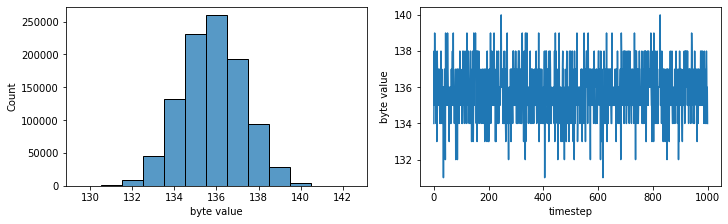

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


KeyboardInterrupt: ignored

In [7]:
for cfg in cfgs:
  logger.info(f'Doing experiment {cfg.name} with params {cfg.params}' )
  with mlflow.start_run(run_name=cfg.inputfile.parent.name):
    metadata_path = next(cfg.inputfile.parent.rglob('*rng.txt'))
    mean,var_alan = get_metadata(metadata_path)
    mlflow.log_param('file',cfg.inputfile)
    mlflow.log_metric('mean_logged',mean)
    mlflow.log_metric('var_alan_logged',var_alan)
    bytes_data = get_bytes_data(cfg.inputfile)
    analyze_series(
        bytes_data,
        **cfg.params
    )

In [298]:
s = '/content/data_v5/220929_S6a1_DBv11-7/acq_20220929143157_cnt.bin'
bytes_data = get_bytes_data(cfg.inputfile)
bytes_data.mean()

byte value    151.635606
dtype: float64

## Summarize

In [96]:
!mlflow experiments csv --experiment-id 0 --filename runs.csv
results = pd.read_csv('runs.csv')

keep_cols = ['tags.mlflow.runName','params.postprocess_fn','metrics.not-correlated.LjungBox.lag_10','metrics.stationary.KPSS.lag_10','metrics.not-stationary.ADF.lag_10']
summary = results[keep_cols].pivot(index='tags.mlflow.runName',columns='params.postprocess_fn').swaplevel(0,1,axis=1)
summary.head()

Experiment with ID 0 has been exported as a CSV to file: runs.csv.


params.postprocess_fn,counter_val,last_bit,counter_val,last_bit,counter_val,last_bit
,metrics.not-correlated.LjungBox.lag_10,metrics.not-correlated.LjungBox.lag_10,metrics.stationary.KPSS.lag_10,metrics.stationary.KPSS.lag_10,metrics.not-stationary.ADF.lag_10,metrics.not-stationary.ADF.lag_10
tags.mlflow.runName,,,,,,
220927_CVa2,1.213934e-307,0.211066,0.01,0.01,0.0,0.0
220928_CVa1,1.711470e-68,0.000799,0.01,0.01,0.0,0.0
220928_CVa1_PR_DBv11-10,7.687458e-220,0.874879,0.01,0.10,0.0,0.0
220928_CVa2_PR_DBv11-10,2.986121e-56,0.250318,0.01,0.10,0.0,0.0
220928_CVa4,7.519899e-56,0.936774,0.01,0.10,0.0,0.0


In [159]:
style_passed = 'color:DarkGreen; font-weight: bold'
styled_results = summary\
  .style\
  .format(precision=3,escape="latex")\
  .applymap(lambda x: style_passed if x<0.05 else '', subset=[('counter_val','metrics.stationary.KPSS.lag_10')])\
  .applymap(lambda x: style_passed if x<0.05 else '', subset=[('last_bit','metrics.stationary.KPSS.lag_10')])\
  .applymap(lambda x: style_passed if x>=0.05 else '', subset=[('counter_val','metrics.not-stationary.ADF.lag_10')])\
  .applymap(lambda x: style_passed if x>=0.05 else '', subset=[('last_bit','metrics.not-stationary.ADF.lag_10')])\
  .applymap(lambda x: style_passed if x>=0.05 else '', subset=[('counter_val','metrics.not-correlated.LjungBox.lag_10')])\
  .applymap(lambda x: style_passed if x>=0.05 else '', subset=[('last_bit','metrics.not-correlated.LjungBox.lag_10')])
styled_results

params.postprocess_fn,counter_val,last_bit,counter_val,last_bit,counter_val,last_bit
,metrics.not-correlated.LjungBox.lag_10,metrics.not-correlated.LjungBox.lag_10,metrics.stationary.KPSS.lag_10,metrics.stationary.KPSS.lag_10,metrics.not-stationary.ADF.lag_10,metrics.not-stationary.ADF.lag_10
tags.mlflow.runName,,,,,,
220927_CVa2,0.000,0.211,0.010,0.010,0.000,0.000
220928_CVa1,0.000,0.001,0.010,0.010,0.000,0.000
220928_CVa1_PR_DBv11-10,0.000,0.875,0.010,0.100,0.000,0.000
220928_CVa2_PR_DBv11-10,0.000,0.250,0.010,0.100,0.000,0.000
220928_CVa4,0.000,0.937,0.010,0.100,0.000,0.000
220929_S6a1_DBv11-7,0.000,0.001,0.100,0.075,0.000,0.000
220929_S6a2_DBv11-7,0.000,0.060,0.010,0.100,0.000,0.000
220929_S6a4_DBv11-7,0.000,0.818,0.100,0.100,0.000,0.000


In [160]:
latex_code = styled_results\
  .to_latex(
      hrules=True,
      convert_css=True,
      position_float = 'centering',
      caption='Results of correlation and stationarity tests',
      label='tab:correlation_and_stationarity'
    )
print(latex_code.replace('_','\_'))

\begin{table}
\centering
\caption{Results of correlation and stationarity tests}
\label{tab:correlation\_and\_stationarity}
\begin{tabular}{lrrrrrr}
\toprule
{params.postprocess\_fn} & {counter\_val} & {last\_bit} & {counter\_val} & {last\_bit} & {counter\_val} & {last\_bit} \\
{} & {metrics.not-correlated.LjungBox.lag\_10} & {metrics.not-correlated.LjungBox.lag\_10} & {metrics.stationary.KPSS.lag\_10} & {metrics.stationary.KPSS.lag\_10} & {metrics.not-stationary.ADF.lag\_10} & {metrics.not-stationary.ADF.lag\_10} \\
{tags.mlflow.runName} & {} & {} & {} & {} & {} & {} \\
\midrule
220927\_CVa2 & 0.000 & \color{DarkGreen} \bfseries 0.211 & \color{DarkGreen} \bfseries 0.010 & \color{DarkGreen} \bfseries 0.010 & 0.000 & 0.000 \\
220928\_CVa1 & 0.000 & 0.001 & \color{DarkGreen} \bfseries 0.010 & \color{DarkGreen} \bfseries 0.010 & 0.000 & 0.000 \\
220928\_CVa1\_PR\_DBv11-10 & 0.000 & \color{DarkGreen} \bfseries 0.875 & \color{DarkGreen} \bfseries 0.010 & 0.100 & 0.000 & 0.000 \\
220928\_CVa

In [384]:
#importlib.reload(pd)
import pandas as pd
pd.__version__

'1.3.5'

# Notes

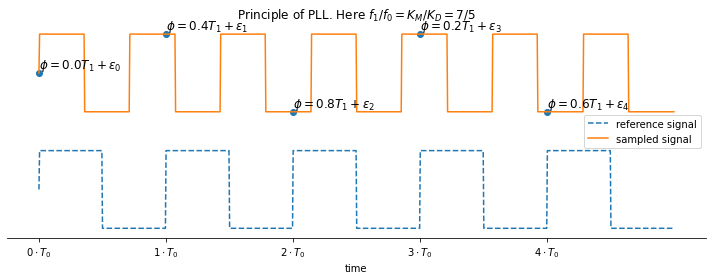

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [10,4]

fig, ax = plt.subplots()
f0 = 5
ts = np.linspace(0,1,1000)
y0= np.sign( np.sin(2*np.pi*f0*ts) )
y0 = -3+y0
ax.plot(ts,y0,linestyle='dashed',label='reference signal')

f1 = 7
y1 = np.sign( np.sin(2*np.pi*f1*ts) )
ax.plot(ts,y1,label='sampled signal')

ts_sampled = np.arange(int(f0))*1/f0
y1_sampled = np.sign( np.sin(2*np.pi*f1*ts_sampled) )
ax.scatter(ts_sampled, y1_sampled)

annotations = ['ble' for _ in ts_sampled]
for i,(text,t,y) in enumerate(zip(annotations,ts_sampled,y1_sampled)):
  phi = np.remainder(t,1/f1)*f1
  phi = phi.round(3)
  ax.text(t,y,f'$\phi={phi} T_1 + \epsilon_{i} $',ha="left", va="bottom",size=12)


ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks([])
ax.set_xticks(ts_sampled)
ax.set_xticklabels([f'${t:.0f}\cdot T_0$' for t in ts_sampled*f0])

ax.legend()
ax.set_title('Principle of PLL. Here $f_1/f_0 = K_M/K_D = 7/5$')# = \frac{7}{5} = \frac{K_M}{K_D}$')
ax.set_xlabel('time')

plt.tight_layout()

The phases of the sampled signal are
$\phi_i = i\cdot \Delta + \epsilon_i \mod T_1 $ where $\Delta = T_1/K_D$ and $\epsilon_i\sim \mathrm{Norm}(0,\sigma^2)$ is the jitter.

We define the counter
$$
N = \sum_{i=1}^{K_D} \mathbb{1}(\phi_i \in (0,T_1/2) )
$$



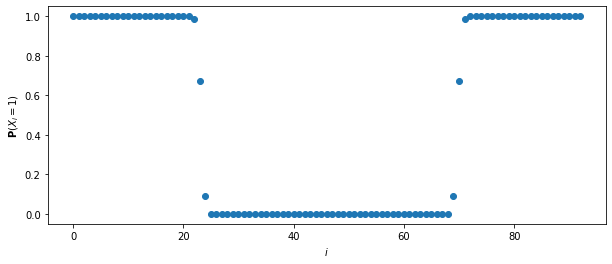

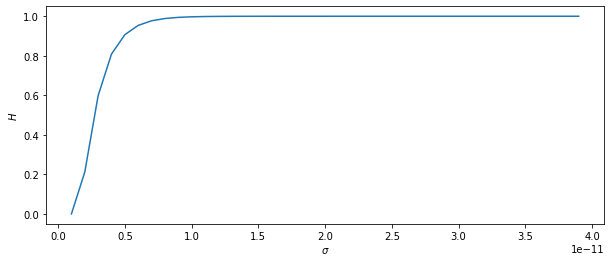

0.5059378032788413 0.9998982659454103


In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from scipy.special import erf

def get_bit_probs_v1(T1,K_D,sigma,phi0_frac):
  """Comuptes probabilities of reordered samples, 
    cf. Eq (4) in "Modern random number generator design – Case study on a secured PLL-based TRNG"""
  i = np.arange(0,K_D) # ordered index from 0 to K_D-1
  Delta = T1/K_D
  phi0 = phi0_frac*T1 # initial_phase
  phi_i = np.remainder(phi0+i*Delta,T1) # signal phases at subsequent samples
  jitter_dist = norm(loc=phi_i,scale=sigma)
  part1 = jitter_dist.cdf(T1/2)-jitter_dist.cdf(0)
  part2 = jitter_dist.cdf(3*T1/2)-jitter_dist.cdf(T1)
  p = part1+part2
  return i,p

def get_bit_probs_v2(T1,K_D,sigma,phi0_frac):
  """Comuptes probabilities of reordered samples, 
    cf. Eq (4) in "Modern random number generator design – Case study on a secured PLL-based TRNG"""
  i = np.arange(0,K_D) # ordered index from 0 to K_D-1
  denom = np.sqrt(2)*sigma/T1
  p = 1- 0.5*erf((i/K_D-phi0_frac)/denom) + 0.5*erf((i/K_D-0.5-phi0_frac)/denom)
  return i,p

get_bit_probs = get_bit_probs_v2

## Test 1: reproduce Fig 7. from "Modern random number generator design – Case study on a secured PLL-based TRNG"

i,ps = get_bit_probs(
  sigma = 9.6*1e-12,
  T1 = 1/( 634.7*1e6 ),
  K_D = 93,
  phi0_frac = 0.25,
)
plt.scatter(i,ps)
plt.xlabel('$i$')
plt.ylabel('$\mathbf{P}(X_i=1)$')
plt.show()

## Test 2: reproduce Fig. 8 (plot 1) from "Modern random number generator design – Case study on a secured PLL-based TRNG"

sigmas = np.arange(1,40)*1e-12
entropy_rates = []
for sigma in sigmas:
  _,ps = get_bit_probs(
    sigma = sigma,
    T1 = 1/( 634.7*1e6 ),
    K_D = 93,
    phi0_frac = 0.25,
  )
  total_p = 1/2+1/2*np.prod(2*ps-1) # as per the formula of Davies
  entropy_rate = entropy([total_p,1-total_p],base=2)
  entropy_rates.append(entropy_rate)

plt.plot(sigmas,entropy_rates)
plt.xlabel('$\sigma$')
plt.ylabel('$H$')
plt.show()

## Test 3: reproduce Tab. 4 (config 1) from "Modern random number generator design – Case study on a secured PLL-based TRNG"

_,ps = get_bit_probs(
  sigma =8.72*1e-12,
  T1 = 1/( 360.1*1e6 ),
  K_D = 279,
  phi0_frac = 0.25, # not sure if we shift the phase?
)

total_p = 1/2+1/2*np.prod(2*ps-1) # as per the formula of Davies
print(total_p,entropy([total_p,1-total_p],base=2))

Artificial reduction!
Reverse the roles of wave and its reference!


* We sample with the reference signal, at frequency $f_0$
* So, rising eges at the sampled signal occur at phases $\phi_i = 
i\cdot T_0 \mod T_1  $
* After rearanging the order, we have $\phi_j = i / K_D \cdot T_1$ where $f_1/f_0 = K_M/K_D$
* In the jitter setup, we assume $\phi_j \sim  i / K_D + \epsilon_j \mod T_1$ where $\epsilon_j \sim N(0,\sigma^2)$
* The bit is one when $\phi_i \in [0,T_1/2]$ and zero otherwise


The equivalent model: the rising edges appear at times $t_i = i\cdot T_0 + \epsilon_i$, we emit $b_i=1$ when
$t_i \mod T_1 < T_1/2$ and $b_i=0$ otherwise.

Then we can apply Schindler's Paper!

We have $\Delta t_i  \sim \epsilon_i - \epsilon_{i-1}$ is 2-independent.


How to estimate entropy
$$
\mathbf{H}(Y_n | Y_{1},\ldots,Y_{n}) \geqslant \mathbf{H}(Y_n | R_{n-1})
$$

so 
$$
\sum_i \mathbf{1}_{0,T/2}(t_i \mod T)
$$







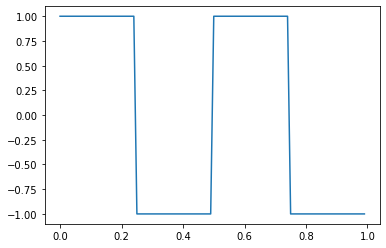

In [ ]:
#from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
ts = np.linspace(0, 1, 100, endpoint=False)
wave = signal.square(2*np.pi*ts*2)
plt.plot(ts, wave)

## Correlations

In [ ]:
def dff_plot(filename, KM, KD):
    raw_data = np.fromfile(filename, dtype="uint8")
    
    # read data choosing the order
    bin_data = np.unpackbits(raw_data, axis=None, count=None, bitorder='little')
    bin_data[0:32]=bin_data[31::-1]
    for i in range(len(bin_data)//32):
        if i>0:
            bin_data[(i*32):((i+1)*32)]=bin_data[((i+1)*32)-1:(i*32)-1:-1]
    #np.savetxt("bin_data.csv", bin_data, delimiter="\t")
    
    # cut Tq periods according to KD
    if len(bin_data)%KD>0:
        bin_data=np.resize(bin_data,(len(bin_data)//KD)*KD) ;# cut last Tq if not full
    img = np.reshape(bin_data,((len(bin_data)//KD),KD)) # (N_CYCLES, KD)
    #np.savetxt("img.csv", img, delimiter="\t")
    
    # reorder Tq period
    j=[(i*KM)%KD for i in range(KD)] ;# reordered period
    somme=np.sum(img,0)    ;# sum by position
    nsum=somme / len(img)  ;# normalized sum
    z=zip(j,nsum)          ;# zip position and values
    uz=list(zip(*sorted(z)))    ;# sort and unzip
    periode=uz[1]

    # plot Tq period
    x=range(0, KD)
    y=periode
    plt.plot(x,y,'+', markersize=4)
    plt.xlabel('$K_D$', fontsize = 12, family = 'serif')
    plt.ylabel('P(X=1)', fontsize = 12, family = 'serif')
    plt.savefig(filename[:-4] + '.pdf')
    plt.show()



def read_dff(filename, KM, KD):
    raw_data = np.fromfile(filename, dtype="uint8")
    
    # read data choosing the order
    bin_data = np.unpackbits(raw_data, axis=None, count=None, bitorder='little')
    bin_data[0:32]=bin_data[31::-1]
    for i in range(len(bin_data)//32):
        if i>0:
            bin_data[(i*32):((i+1)*32)]=bin_data[((i+1)*32)-1:(i*32)-1:-1]
    #np.savetxt("bin_data.csv", bin_data, delimiter="\t")
    
    # cut Tq periods according to KD
    if len(bin_data)%KD>0:
        bin_data=np.resize(bin_data,(len(bin_data)//KD)*KD) ;# cut last Tq if not full
    img = np.reshape(bin_data,((len(bin_data)//KD),KD)) # (N_CYCLES, KD)
    return img


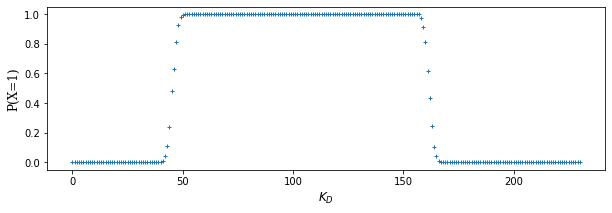

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

filename = '/content/data_CV_c_and_CV_d_dff/CVd1/acq_20221005094040_dff.bin'
KM = 470
KD = 231
dff_plot(filename=filename,KM=KM,KD=KD)

Index i of random bits in time domain:
[113 118 123 128 230 235 240 245]
Correponding position j(i) of random bits:
[ 77  76  75  74 203 202 201 200]
Ordered position j(i) of random bits:
[ 74  75  76  77 200 201 202 203]


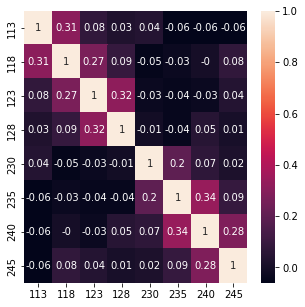

[[ 1.    0.31  0.08  0.03  0.04 -0.06 -0.06 -0.06]
 [ 0.31  1.    0.27  0.09 -0.05 -0.03 -0.    0.08]
 [ 0.08  0.27  1.    0.32 -0.03 -0.04 -0.03  0.04]
 [ 0.03  0.09  0.32  1.   -0.01 -0.04  0.05  0.01]
 [ 0.04 -0.05 -0.03 -0.01  1.    0.2   0.07  0.02]
 [-0.06 -0.03 -0.04 -0.04  0.2   1.    0.34  0.09]
 [-0.06 -0.   -0.03  0.05  0.07  0.34  1.    0.28]
 [-0.06  0.08  0.04  0.01  0.02  0.09  0.28  1.  ]]
Most correlated bits are [235 240]  with correlation 0.34
Index i of random bits in time domain:
[  6  20  34  35  49  63  64  78  92  93 107 121 136 150 165 179 193 194
 208 222]
Correponding position j(i) of random bits:
[ 48 160  41  49 161  42  50 162  43  51 163  44 164  45 165  46 158 166
  47 159]
Ordered position j(i) of random bits:
[ 41  42  43  44  45  46  47  48  49  50  51 158 159 160 161 162 163 164
 165 166]


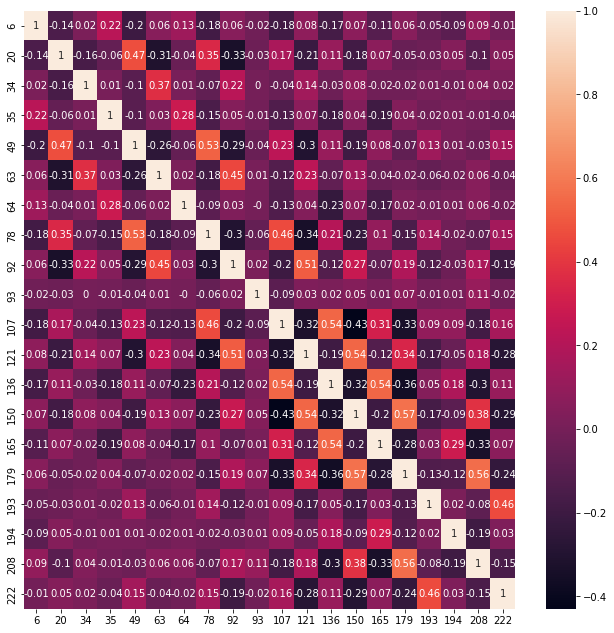

[[ 1.   -0.14  0.02  0.22 -0.2   0.06  0.13 -0.18  0.06 -0.02 -0.18  0.08
  -0.17  0.07 -0.11  0.06 -0.05 -0.09  0.09 -0.01]
 [-0.14  1.   -0.16 -0.06  0.47 -0.31 -0.04  0.35 -0.33 -0.03  0.17 -0.21
   0.11 -0.18  0.07 -0.05 -0.03  0.05 -0.1   0.05]
 [ 0.02 -0.16  1.    0.01 -0.1   0.37  0.01 -0.07  0.22  0.   -0.04  0.14
  -0.03  0.08 -0.02 -0.02  0.01 -0.01  0.04  0.02]
 [ 0.22 -0.06  0.01  1.   -0.1   0.03  0.28 -0.15  0.05 -0.01 -0.13  0.07
  -0.18  0.04 -0.19  0.04 -0.02  0.01 -0.01 -0.04]
 [-0.2   0.47 -0.1  -0.1   1.   -0.26 -0.06  0.53 -0.29 -0.04  0.23 -0.3
   0.11 -0.19  0.08 -0.07  0.13  0.01 -0.03  0.15]
 [ 0.06 -0.31  0.37  0.03 -0.26  1.    0.02 -0.18  0.45  0.01 -0.12  0.23
  -0.07  0.13 -0.04 -0.02 -0.06 -0.02  0.06 -0.04]
 [ 0.13 -0.04  0.01  0.28 -0.06  0.02  1.   -0.09  0.03 -0.   -0.13  0.04
  -0.23  0.07 -0.17  0.02 -0.01  0.01  0.06 -0.02]
 [-0.18  0.35 -0.07 -0.15  0.53 -0.18 -0.09  1.   -0.3  -0.06  0.46 -0.34
   0.21 -0.23  0.1  -0.15  0.14 -0.02 -0.07  0.15]
 

(13, 15)

In [ ]:
def test_correlation(filename,KM,KD):
  img = read_dff(filename=filename,KD=KD,KM=KM)

  probs = img.mean(0) # (KD,)
  mask = (probs > prob_ts) & (probs < 1-prob_ts) # exclude deterministic samples
  non_trivial_bits = img[:,mask]

  non_trivial_is = np.arange(KD)[mask]
  non_trivial_js =  non_trivial_is * KM % KD
  print('Index i of random bits in time domain:')
  print(non_trivial_is)
  print('Correponding position j(i) of random bits:')
  print(non_trivial_js)
  non_trivial_js.sort()
  print('Ordered position j(i) of random bits:')
  print(non_trivial_js)

  # Adapting the figsize to the dimension of the heatmap
  plt.rcParams['figure.figsize'] = [1+sum(mask)/2,1+sum(mask)/2]

  pearson_corr = np.corrcoef(non_trivial_bits.T).round(2)
  sns.heatmap(
      data=pearson_corr,
      annot=True,
      xticklabels=non_trivial_is,
      yticklabels=non_trivial_is)
  plt.show()
  print(pearson_corr)
  return pearson_corr, non_trivial_is


def find_worst_correlation(corrs, bit_pos):
  # Artificially ignore the diagonal coefficients
  for i in range(len(corrs)):
    corrs[i,i]=0
  
  worst_corr_pos = np.unravel_index(np.argmax(np.abs(corrs), axis=None), corrs.shape)
  worst_corr_bits = bit_pos.take(worst_corr_pos)
  print(f'Most correlated bits are {worst_corr_bits}',
        f' with correlation {corrs[worst_corr_pos]}')
  return worst_corr_pos


# Treshold to exclude "not random enough" bits of interest
# Should be between 0 (exclude none) and 1/2 (exclude all)
prob_ts = 0

filename = '/content/data_CV_c_and_CV_d_dff/CVc1/acq_20221005092918_dff.bin'
KM=448
KD=249
corr_matrix, i_values = test_correlation(filename,KM,KD)
find_worst_correlation(corr_matrix, i_values)

filename = '/content/data_CV_c_and_CV_d_dff/CVd1/acq_20221005094040_dff.bin'
KM = 470
KD = 231
corr_matrix, i_values = test_correlation(filename,KM,KD)
find_worst_correlation(corr_matrix, i_values)

In [ ]:
print(corr_matrix)

[[ 0.   -0.14  0.02  0.22 -0.2   0.06  0.13 -0.18  0.06 -0.02 -0.18  0.08
  -0.17  0.07 -0.11  0.06 -0.05 -0.09  0.09 -0.01]
 [-0.14  0.   -0.16 -0.06  0.47 -0.31 -0.04  0.35 -0.33 -0.03  0.17 -0.21
   0.11 -0.18  0.07 -0.05 -0.03  0.05 -0.1   0.05]
 [ 0.02 -0.16  0.    0.01 -0.1   0.37  0.01 -0.07  0.22  0.   -0.04  0.14
  -0.03  0.08 -0.02 -0.02  0.01 -0.01  0.04  0.02]
 [ 0.22 -0.06  0.01  0.   -0.1   0.03  0.28 -0.15  0.05 -0.01 -0.13  0.07
  -0.18  0.04 -0.19  0.04 -0.02  0.01 -0.01 -0.04]
 [-0.2   0.47 -0.1  -0.1   0.   -0.26 -0.06  0.53 -0.29 -0.04  0.23 -0.3
   0.11 -0.19  0.08 -0.07  0.13  0.01 -0.03  0.15]
 [ 0.06 -0.31  0.37  0.03 -0.26  0.    0.02 -0.18  0.45  0.01 -0.12  0.23
  -0.07  0.13 -0.04 -0.02 -0.06 -0.02  0.06 -0.04]
 [ 0.13 -0.04  0.01  0.28 -0.06  0.02  0.   -0.09  0.03 -0.   -0.13  0.04
  -0.23  0.07 -0.17  0.02 -0.01  0.01  0.06 -0.02]
 [-0.18  0.35 -0.07 -0.15  0.53 -0.18 -0.09  0.   -0.3  -0.06  0.46 -0.34
   0.21 -0.23  0.1  -0.15  0.14 -0.02 -0.07  0.15]
 

### Stationarity/Correlation Experiment

In [ ]:
filename = '/content/data_CV_c_and_CV_d_dff/CVd1/acq_20221005094040_dff.bin'
KM = 470
KD = 231

img = read_dff(filename=filename,KD=KD,KM=KM)
img.shape

(346, 231)

In [ ]:
position_j = 0
bytes_series = img[:,position_j]
results = kpss(bytes_series,nlags=10)
results[1]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

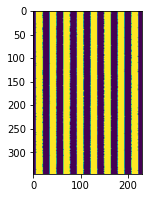

In [ ]:
plt.imshow(img)

For rows $i$ (subsequent $T_Q$ periods), we consider samples $j=0..K_D-1$
$$
X_{i,j}
$$

Then
- Stationarity for $X_{i,\bullet}$ for every $j$-fixed.
- Independentce of $X_{\bullet,j}$ (also used when XORing, Dav02)

give us stationarity of the group of bits $X_{i,\bullet}$



